In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
kpi_data = tfcu_data.groupby('Week')[['Member_Retention', 'Employee_Retention',
       'Member_Satisfaction_NPS', 'Fraud_Rate', 'Employee_Satisfaction',
       'Number_of_Employee Relations_Issues', 'No_of_Member_Complaints',
       'Member_Acquisition_Cost', 'Number_of_Compliance_Issues',
       'Compliance_Investigation_Cycle_Time', 'Decline_Rate',
       'Financial_Impact_Due_to_Attacks',
       'Attempted_vs_Fraudulent_Transactions', 'Final_Approval_Rate',
       'Fraudulent_Vs_Declined_Transactions', 'System_Uptime',
       'Severity_of_attacks', 'Mean_Time_Between_Failures',
       'Cost_per_Incident', 'Number_of_Cybersecurity_Incidents_Reported']].mean().reset_index().drop('Week', axis= 1)

### Stepwise Linear Regression Analysis

In [4]:
kpi_dependency_dict = {}
for i in kpi_data.columns:  
    X = kpi_data.drop(columns=[i])  # Drop the target column to get the features
    y = kpi_data[i]  # Select the target column

    # Perform stepwise regression
    # Initialize the stepwise regression model
    sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                    k_features= 'best',
                                    forward=False, 
                                    floating=True,  
                                    scoring='neg_mean_squared_error',
                                    cv=5)

    # Fit the stepwise regression model to the data
    sfs.fit(X, y)

    # Print the selected features
    kpi_dependency_dict[i] = sfs.k_feature_names_

### Overall Graph

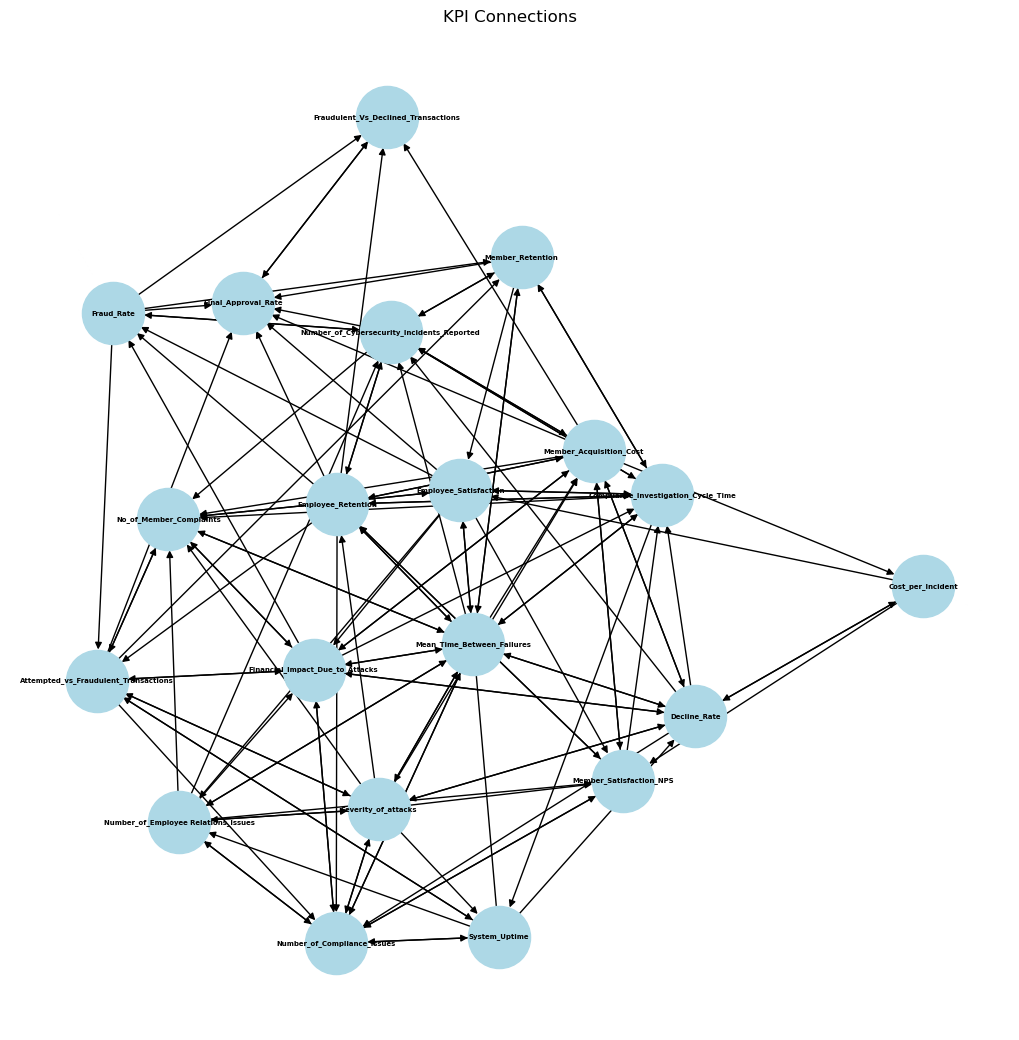

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for kpi, connected_kpis in kpi_dependency_dict.items():
    G.add_node(kpi)
    for connected_kpi in connected_kpis:
        G.add_edge(kpi, connected_kpi)


# # Set the desired distance between nodes
# desired_distance = 5
# # Calculate the optimal distance between nodes based on the number of nodes
# optimal_distance = len(G.nodes()) ** -0.5 * desired_distance
# # Draw the graph
# pos = nx.spring_layout(G, k = optimal_distance)

plt.figure(figsize=(10, 10))

# Draw the graph with the Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

# pos = nx.fruchterman_reingold_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=5, font_weight="bold")
plt.title("KPI Connections")
plt.show()


### Subset Graph

In [10]:
# import json
# with open('kpi_relation.json', 'r') as f:
#     kpi_relation = json.load(f)

# kpi_relation.keys()

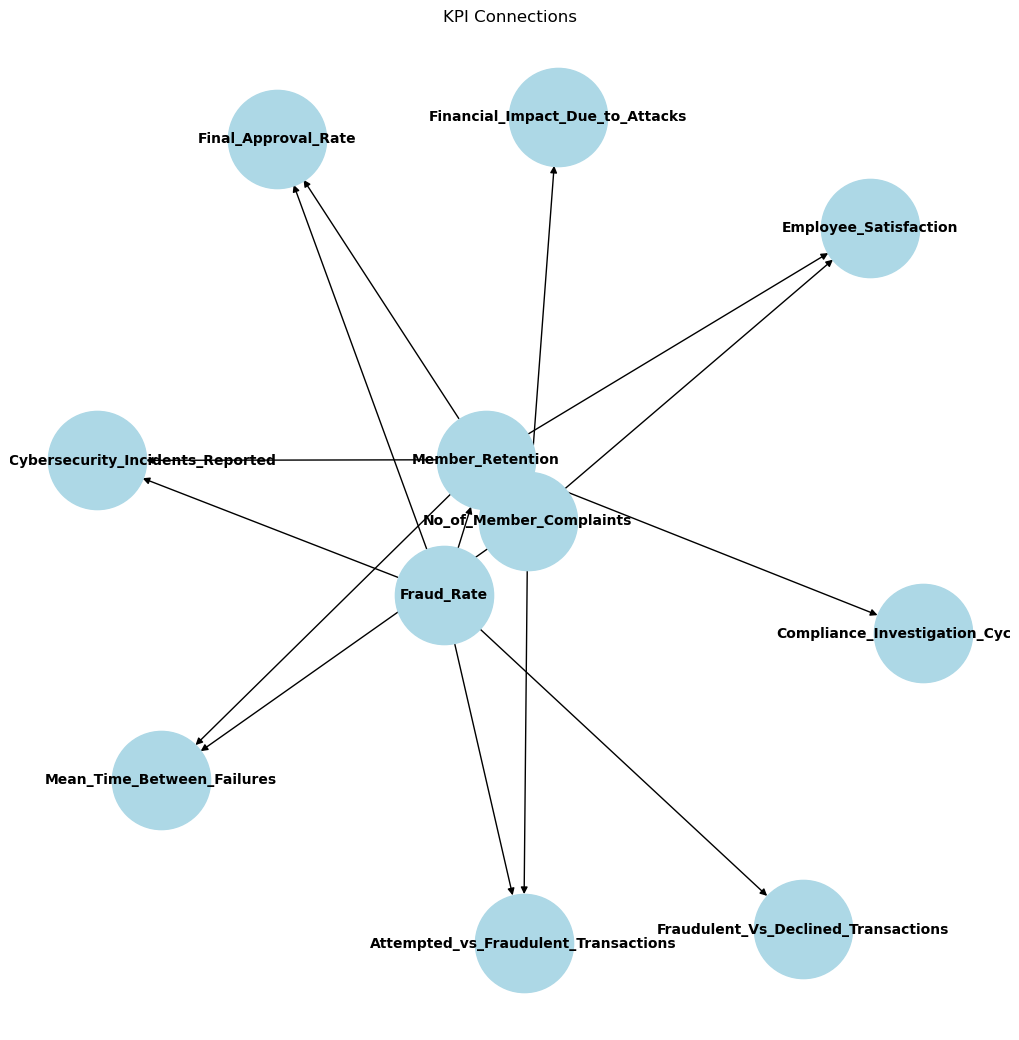

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Change the list for differen relations
subset_list = ['Member_Retention', 'Fraud_Rate', 'No_of_Member_Complaints']
kpi_relation_subset = {key: kpi_dependency_dict[key] for key in subset_list}

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for kpi, connected_kpis in kpi_relation_subset.items():
    G.add_node(kpi)
    for connected_kpi in connected_kpis:
        G.add_edge(kpi, connected_kpi)


# # Set the desired distance between nodes
# desired_distance = 5
# # Calculate the optimal distance between nodes based on the number of nodes
# optimal_distance = len(G.nodes()) ** -0.5 * desired_distance
# # Draw the graph
# pos = nx.spring_layout(G, k = optimal_distance)

plt.figure(figsize=(10, 10))

# Draw the graph with the Kamada-Kawai layout
# pos = nx.kamada_kawai_layout(G)

pos = nx.fruchterman_reingold_layout(G)

nx.draw(G, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10, font_weight="bold")
plt.title("KPI Connections")
plt.show()

In [17]:
# Normalized Coefficients
import json
with open('kpi.json', 'r') as f:
    kpi_scaled = json.load(f)

kpi_scaled['Member_Retention']

{'Features': ['Fraud_Rate',
  'Number_of_Compliance_Issues',
  'Attempted_vs_Fraudulent_Transactions',
  'Severity_of_attacks',
  'Cost_per_Incident'],
 'Importance': [-0.6713417627546328,
  0.6455282450788566,
  0.7059631002171494,
  1.0913237779517304,
  -1.7710409486905334],
 'Intercept': 74.51842275980195}

In [16]:
with open('kpi_unscaled.json', 'r') as f:
    kpi_unscaled = json.load(f)

kpi_unscaled['Member_Retention']

{'Features': ['Employee_Satisfaction',
  'Compliance_Investigation_Cycle_Time',
  'Final_Approval_Rate',
  'Fraudulent_Vs_Declined_Transactions',
  'Mean_Time_Between_Failures',
  'Number_of_Cybersecurity_Incidents_Reported'],
 'Importance': [-1.2607357047035328,
  0.2806644543821131,
  0.28070103388355294,
  0.28070103388356793,
  0.2005188383926005,
  -3.957633404895047],
 'Intercept': 31.91024054213068}

### Normalization for data

In [19]:
kpi_dependency_dict = {}
for i in kpi_data.columns: 
    scaler = MinMaxScaler() 
    X = kpi_data.drop(columns=[i])  # Drop the target column to get the features
    X_scaled = scaler.fit_transform(X)
    y = kpi_data[i]  # Select the target column
    x_dict = {}
    # Perform stepwise regression
    # Initialize the stepwise regression model
    sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                    k_features= 'best',
                                    forward=False, 
                                    floating=True,  
                                    scoring='neg_mean_squared_error',
                                    cv=5)

    # Fit the stepwise regression model to the data
    sfs.fit(X_scaled, y)

    # Print the selected features
    # list_x = [int(i) for i in sfs.k_feature_names_]
    x_dict['Features'] = [kpi_data.columns[int(j)] for j in sfs.k_feature_names_]

    model = linear_model.LinearRegression()
    model = model.fit(X_scaled[:, [int(j) for j in sfs.k_feature_names_]], y)
    

    x_dict['Importance'] = list(model.coef_.reshape(-1))
    x_dict['Intercept'] = model.intercept_

    kpi_dependency_dict[i] = x_dict

In [20]:
kpi_dependency_dict['Member_Retention']

{'Features': ['Fraud_Rate',
  'Number_of_Compliance_Issues',
  'Attempted_vs_Fraudulent_Transactions',
  'Severity_of_attacks',
  'Cost_per_Incident'],
 'Importance': [-0.2316149121737412,
  0.6885124186142269,
  0.7307396404464264,
  1.0,
  -1.0],
 'Intercept': 74.51842275980195}

In [11]:
# import json
# with open('kpi_normalized.json', 'w') as f :
#     json.dump(kpi_dependency_dict, f)

In [8]:
def normalize(values):
    min_val = min(values)
    max_val = max(values)
    normalized_values = [(2 * (x - min_val) / (max_val - min_val)) - 1 for x in values]
    return normalized_values

In [9]:
kpi_dependency_dict = {}
for i in kpi_data.columns: 
    scaler = MinMaxScaler() 
    X = kpi_data.drop(columns=[i])  # Drop the target column to get the features
    X_scaled = scaler.fit_transform(X)
    y = kpi_data[i]  # Select the target column
    x_dict = {}
    # Perform stepwise regression
    # Initialize the stepwise regression model
    sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                    k_features= 'best',
                                    forward=False, 
                                    floating=True,  
                                    scoring='neg_mean_squared_error',
                                    cv=5)

    # Fit the stepwise regression model to the data
    sfs.fit(X_scaled, y)

    # Print the selected features
    # list_x = [int(i) for i in sfs.k_feature_names_]
    x_dict['Features'] = [kpi_data.columns[int(j)] for j in sfs.k_feature_names_]

    model = linear_model.LinearRegression()
    model = model.fit(X_scaled[:, [int(j) for j in sfs.k_feature_names_]], y)
    

    x_dict['Importance'] = normalize(list(model.coef_.reshape(-1)))
    x_dict['Intercept'] = model.intercept_

    kpi_dependency_dict[i] = x_dict